<a href="https://colab.research.google.com/github/savindumahasen/Chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Lang-graph

In [7]:
!pip install langgraph langsmith
!pip install langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.44
    Uninstalling langsmith-0.3.44:
      S

In [4]:
## Use Groq and Lang smith API keys
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')
langsmith_api_key=userdata.get("LANG_SMITH_API_KEY")

In [5]:
## setup the  langsmith APi key
import os
os.environ["LANGCHAIN_API_KEY"]=langsmith_api_key
os.environ["LANCHAIN_TRACING_V2"]="true"
os.environ["LANCHAIN_PROJECT"]="chatbot"

In [9]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ba6ded4dbd0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ba6de8b0950>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Building the chatbot using Langgraph

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [14]:
class State(TypedDict):
  ## Messages have type "list". The add_messages function
  ## In the annotation defines how  this state key should be updated
  ## in this case, append messages to the list rather than overwriting it
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [15]:
graph_builder

In [16]:
def chatbot(state:State):
  return {"message":llm.invoke(state['messages'])}

In [19]:
graph_builder.add_node("chatbot", chatbot)
graph_builder

ValueError: Node `chatbot` already present.

In [21]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)

In [22]:
## compile the graph builder
graph=graph_builder.compile()

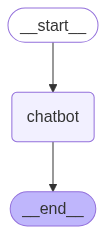

In [23]:
## display the graph

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png()))